In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.95)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 1.1210 | val loss 0.7716 | acc 0.2126 | f1 0.3506 | prec 0.2126 | recall 1.0000 | roc auc 0.5113 | pr auc 0.2443 | elapsed 27.39s
train epoch 01/10 | batch 1704/1703 | loss 0.8685 | val loss 0.5109 | acc 0.8142 | f1 0.3165 | prec 0.7265 | recall 0.2023 | roc auc 0.6477 | pr auc 0.4590 | elapsed 54.49s
train epoch 02/10 | batch 1704/1703 | loss 0.5769 | val loss 0.4410 | acc 0.8209 | f1 0.5297 | prec 0.5993 | recall 0.4746 | roc auc 0.7728 | pr auc 0.6025 | elapsed 56.32s
train epoch 03/10 | batch 1704/1703 | loss 0.4200 | val loss 0.4451 | acc 0.8234 | f1 0.5868 | prec 0.5836 | recall 0.5901 | roc auc 0.8006 | pr auc 0.6568 | elapsed 54.53s
train epoch 04/10 | batch 1704/1703 | loss 0.3205 | val loss 0.4797 | acc 0.8132 | f1 0.5935 | prec 0.5521 | recall 0.6415 | roc auc 0.8151 | pr auc 0.6853 | elapsed 55.33s
train epoch 05/10 | batch 1704/1703 | loss 0.2533 |

In [7]:
print(T.round(T.matmul(trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100)

tensor([[1., -0., -0., 0., -0., 0., -0., -0., 0., -0.],
        [0., 1., 0., 0., 0., 0., -0., 0., -0., -0.],
        [-0., 0., 1., 0., -0., -0., -0., 0., 0., 0.],
        [0., -0., -0., 1., -0., -0., 0., -0., 0., 0.],
        [0., -0., -0., -0., 1., 0., 0., -0., 0., -0.],
        [-0., -0., -0., 0., -0., 1., 0., -0., 0., -0.],
        [0., 0., -0., 0., -0., 0., 1., 0., -0., -0.],
        [-0., -0., -0., 0., -0., 0., -0., 1., 0., -0.],
        [0., -0., 0., 0., 0., -0., -0., 0., 1., 0.],
        [-0., -0., -0., 0., 0., -0., -0., -0., 0., 1.]],
       grad_fn=<DivBackward0>)


In [8]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, identities_weight=0.01, identitity_weight_decay=0.95)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 0.9912 | val loss 1.1844 | acc 0.6441 | f1 0.4241 | prec 0.3194 | recall 0.6307 | roc auc 0.6960 | pr auc 0.4727 | elapsed 12.16s
train epoch 01/10 | batch 849/848 | loss 0.8684 | val loss 1.0298 | acc 0.6699 | f1 0.4466 | prec 0.3427 | recall 0.6412 | roc auc 0.7247 | pr auc 0.5056 | elapsed 20.94s
train epoch 02/10 | batch 849/848 | loss 0.6315 | val loss 0.9140 | acc 0.6930 | f1 0.4743 | prec 0.3681 | recall 0.6667 | roc auc 0.7510 | pr auc 0.5383 | elapsed 19.80s
train epoch 03/10 | batch 849/848 | loss 0.4651 | val loss 0.8310 | acc 0.7090 | f1 0.4905 | prec 0.3854 | recall 0.6742 | roc auc 0.7726 | pr auc 0.5689 | elapsed 19.95s
train epoch 04/10 | batch 849/848 | loss 0.3546 | val loss 0.7716 | acc 0.7228 | f1 0.5073 | prec 0.4022 | recall 0.6869 | roc auc 0.7897 | pr auc 0.5964 | elapsed 21.01s
train epoch 05/10 | batch 849/848 | loss 0.2826 | val loss 0.7279 | acc 0.7350 | f1 0.5250 | prec 0.4182 | recall 0.7049 | roc a

In [9]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240716T175341


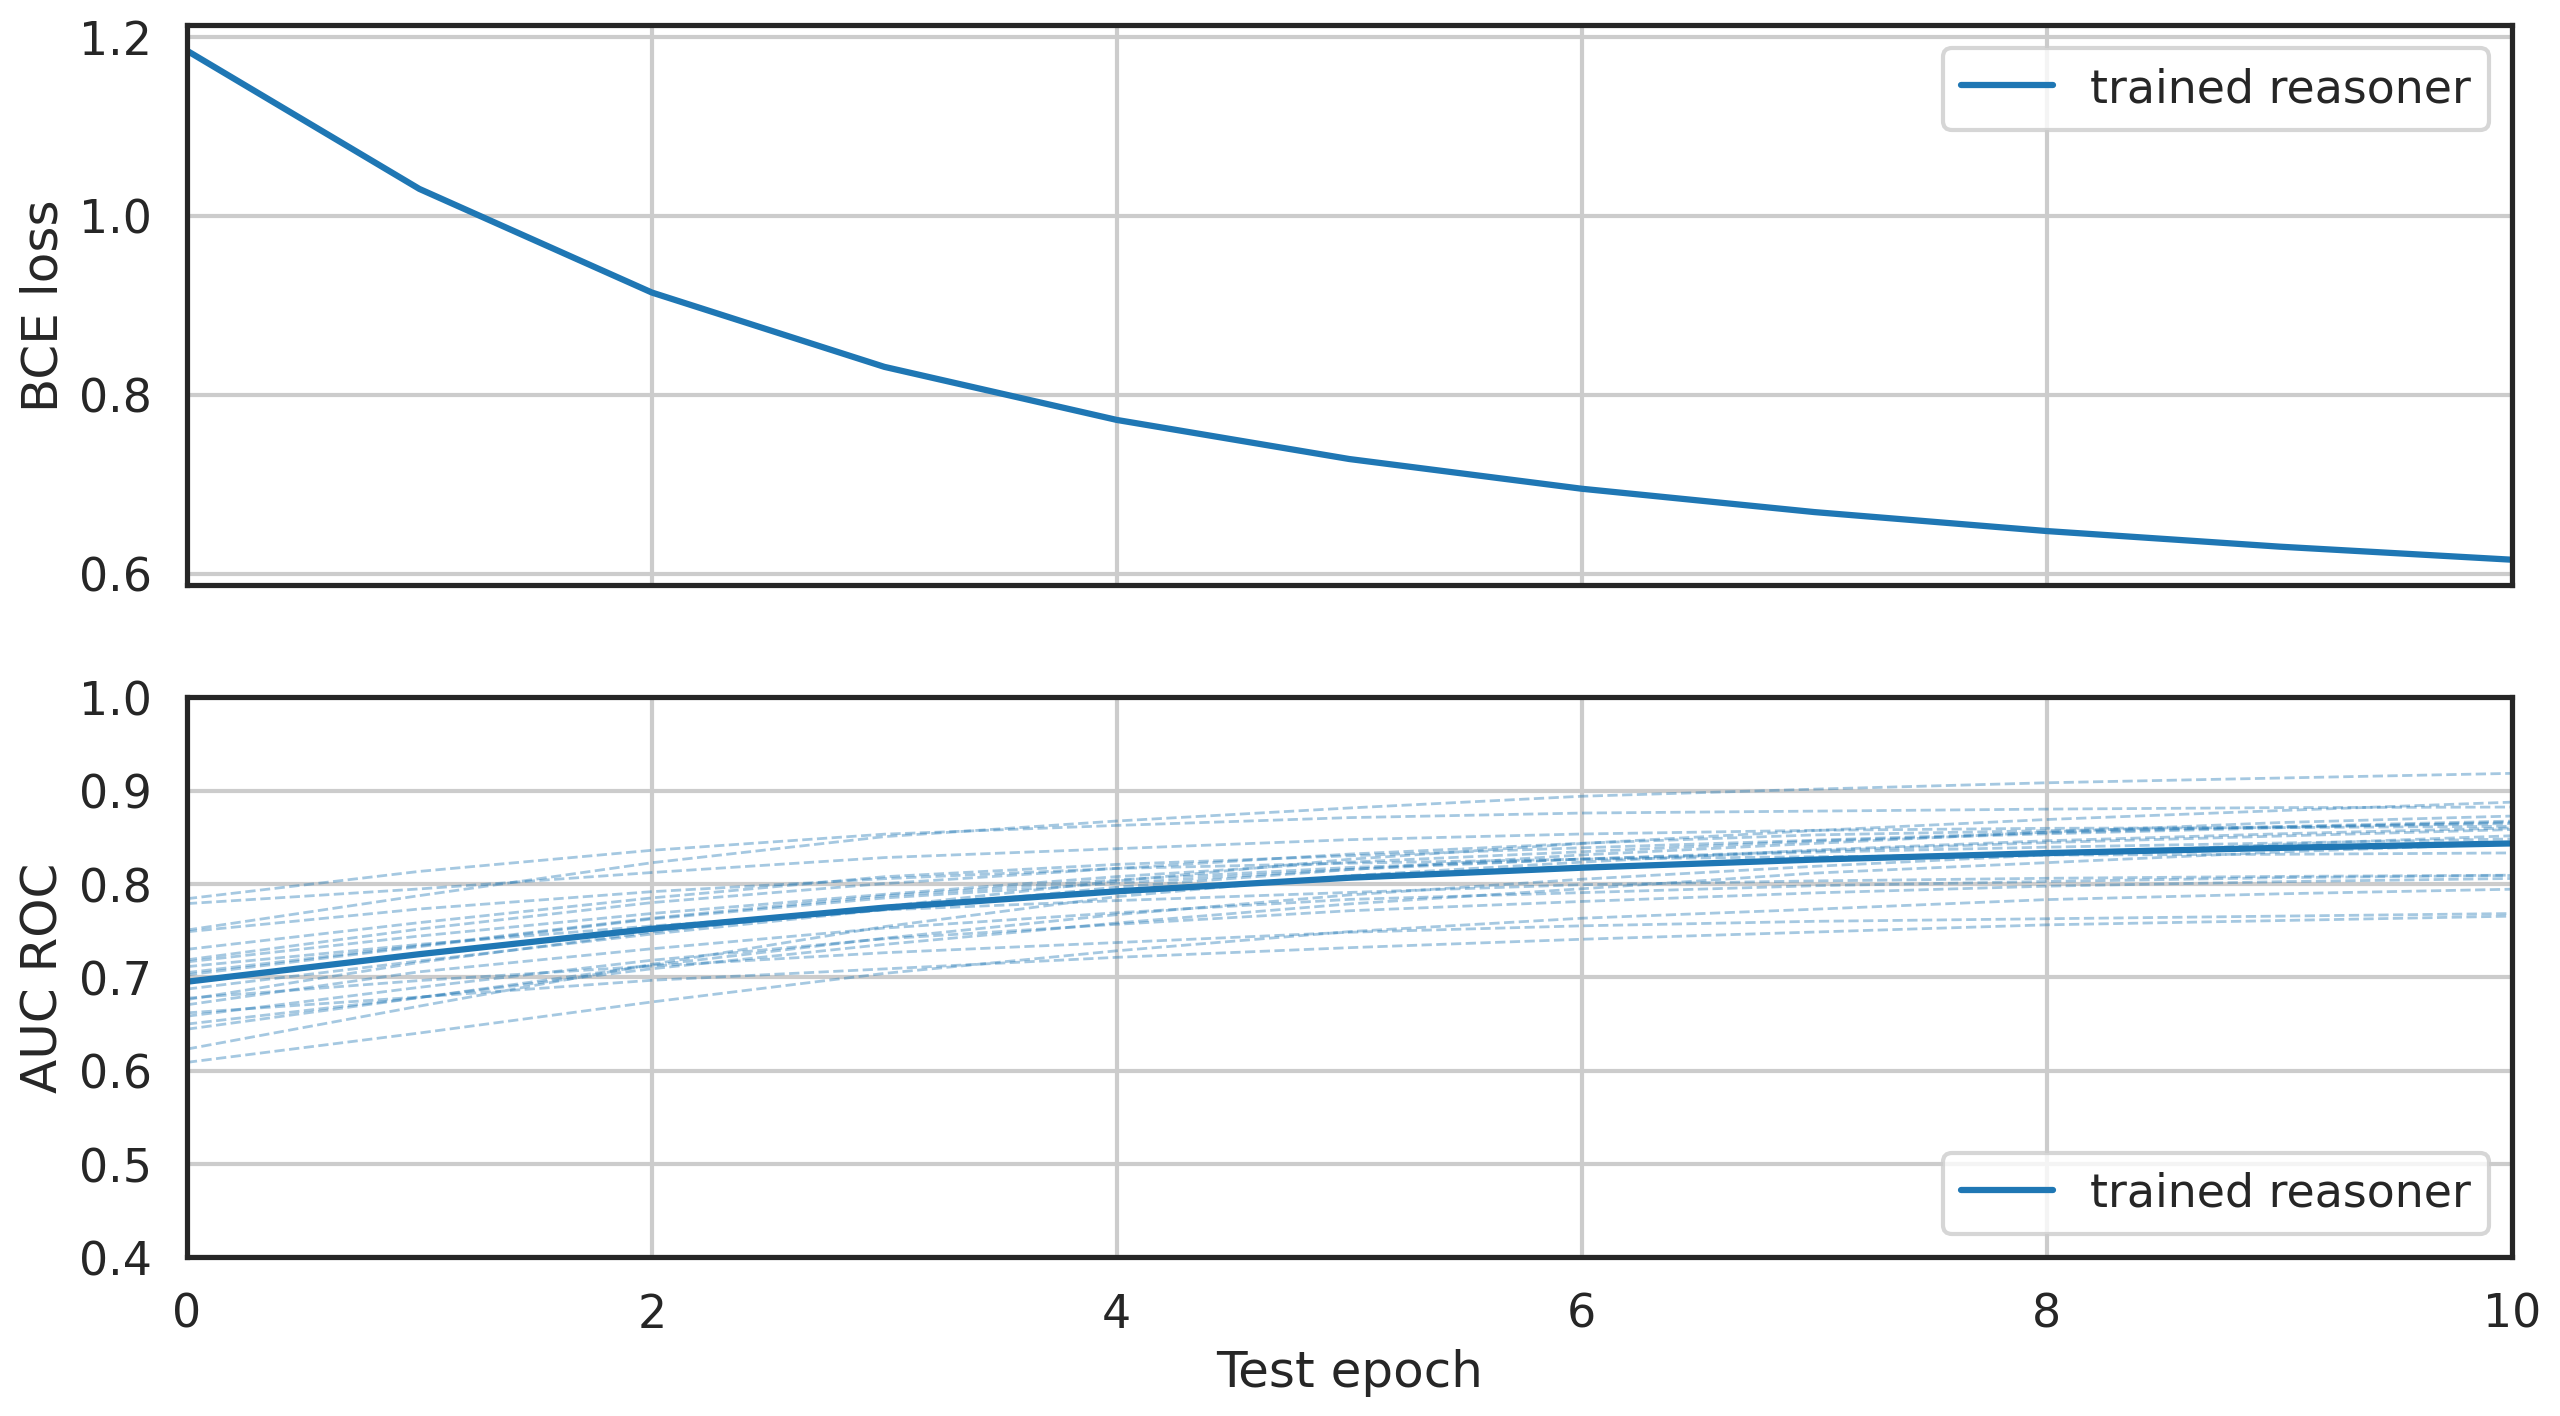

             mean       std     micro
acc      0.793577  0.059394  0.794035
prec     0.515902  0.114757  0.504873
recall   0.775569  0.066853  0.769688
f1       0.611713  0.085128  0.609770
auc_roc  0.860878  0.046508  0.860831
auc_pr   0.740363  0.087479  0.741135


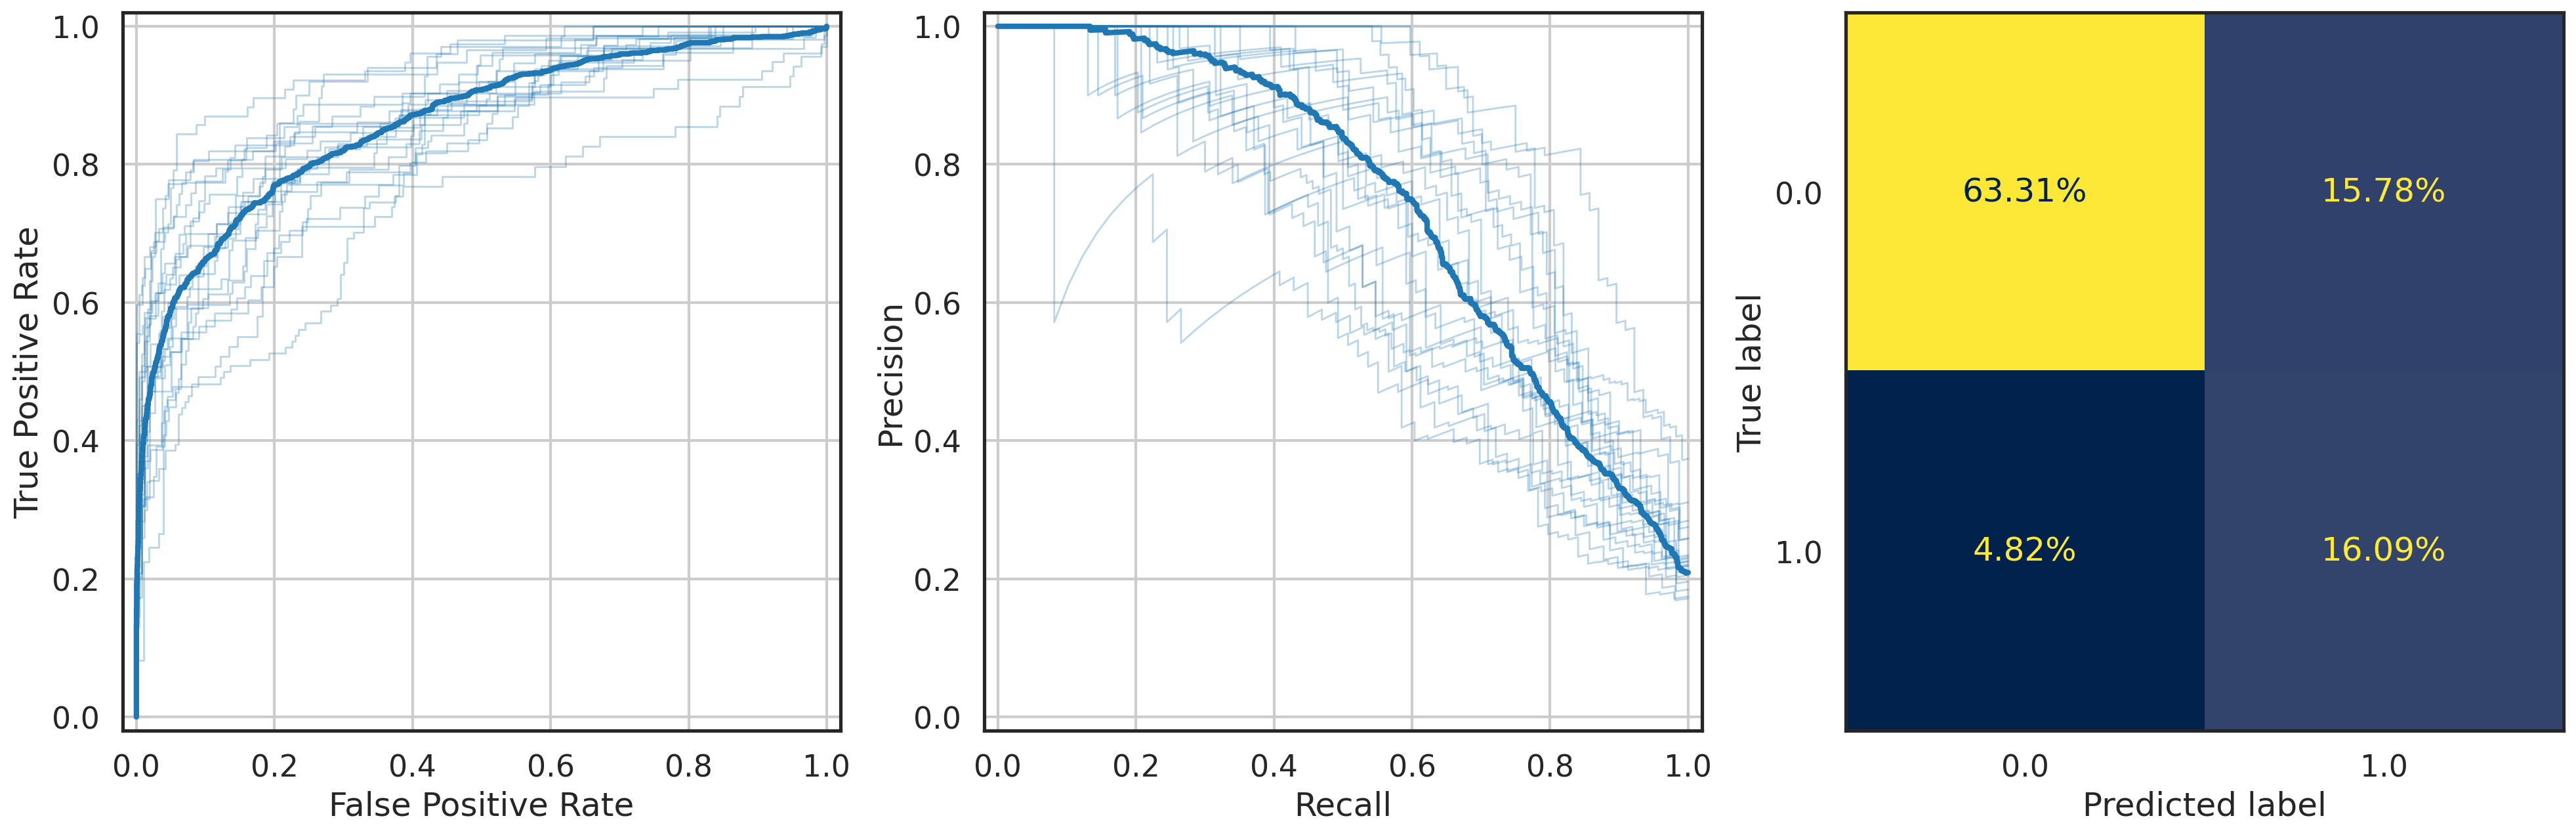

In [10]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# # df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [11]:
import random

In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.1002, -0.1286,  0.0518, -0.2420, -0.1483, -0.1141,  0.1137, -0.2711,
         0.0982, -0.0990], grad_fn=<SelectBackward0>)
tensor([ 0.1240, -0.0855,  0.1013, -0.1700,  0.1306, -0.1088, -0.0802, -0.1332,
         0.0367,  0.0655], grad_fn=<AddBackward0>)
0.1329256057739258


In [13]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.3879,  0.2801,  0.0696, -0.3775,  0.4681, -0.0520,  0.1359,  0.2052,
        -0.3164, -0.1716], grad_fn=<SelectBackward0>)
tensor([ 0.4305,  0.3075,  0.0509, -0.3872,  0.4831, -0.0084,  0.1587,  0.2492,
        -0.3606, -0.1970], grad_fn=<AddBackward0>)
0.027469025738537312


In [14]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.1075, -0.0145, -0.0647,  0.0140,  0.1839, -0.1817, -0.1721, -0.0028,
        -0.0231, -0.0987], grad_fn=<SelectBackward0>)
tensor([ 0.0242, -0.0067,  0.0073, -0.0547,  0.0650, -0.1013, -0.0599, -0.0114,
        -0.0291, -0.0134], grad_fn=<AddBackward0>)
0.08520813453942537


In [15]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.3879,  0.2801,  0.0696, -0.3775,  0.4681, -0.0520,  0.1359,  0.2052,
        -0.3164, -0.1716], grad_fn=<SelectBackward0>)
tensor([ 0.2364,  0.0341,  0.0956, -0.2469,  0.2282, -0.1171,  0.0073, -0.0190,
        -0.0520, -0.0364], grad_fn=<AddBackward0>)
0.16648840606212617


In [16]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.3879,  0.2801,  0.0696, -0.3775,  0.4681, -0.0520,  0.1359,  0.2052,
        -0.3164, -0.1716], grad_fn=<SelectBackward0>)
tensor([ 0.3907,  0.3218,  0.0730, -0.3764,  0.4919, -0.0517,  0.1292,  0.2312,
        -0.3593, -0.1712], grad_fn=<SqueezeBackward3>)
tensor(0.0149, grad_fn=<L1LossBackward0>)


In [17]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-1.1503e-01, -3.0737e-01,  2.6565e-02,  6.0657e-01, -6.3124e-04,
         2.3228e-01,  1.0589e+00,  7.9537e-02, -1.1739e-01,  3.4120e-01],
       grad_fn=<SelectBackward0>)
tensor([-1.1345e-01, -2.5891e-01,  3.1440e-02,  6.0154e-01, -9.2009e-04,
         2.1887e-01,  9.8123e-01,  7.9109e-02, -1.1410e-01,  3.3782e-01],
       grad_fn=<SqueezeBackward3>)
tensor(0.0158, grad_fn=<L1LossBackward0>)


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1545,  0.0211,  0.0715, -0.2202,  0.1628, -0.0833, -0.0713,  0.0025,
        -0.0966, -0.0165], grad_fn=<AddBackward0>)
tensor([ 0.1567,  0.0046,  0.0761, -0.2032,  0.1787, -0.0861, -0.0348, -0.0059,
        -0.0992,  0.0051], grad_fn=<AddBackward0>)
0.018095349380746483


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.2109,  0.0481,  0.0835, -0.2314,  0.2590, -0.1076, -0.0895, -0.0203,
        -0.1376, -0.0056], grad_fn=<AddBackward0>)
tensor([ 0.2146,  0.0485,  0.0900, -0.2506,  0.2611, -0.1740, -0.0582, -0.0524,
        -0.1255, -0.0383], grad_fn=<AddBackward0>)
0.027795481868088244


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0858, -0.0458,  0.0415, -0.0827, -0.0205, -0.1984, -0.0085, -0.1682,
         0.0733, -0.1341], grad_fn=<SelectBackward0>)
tensor([ 0.0738, -0.0301,  0.0367, -0.0716,  0.0518, -0.0791, -0.0161, -0.0703,
         0.0178, -0.0412], grad_fn=<AddBackward0>)
0.06113843787461519


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9990941941738128


In [22]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999772310256958


In [23]:
T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.not_nn(input1)))).sum()

tensor(0.0683, grad_fn=<SumBackward0>)

In [24]:
T.round(T.matmul(trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100

tensor([[1., -0., -0., 0., -0., 0., -0., -0., 0., -0.],
        [0., 1., 0., 0., 0., 0., -0., 0., -0., -0.],
        [-0., 0., 1., 0., -0., -0., -0., 0., 0., 0.],
        [0., -0., -0., 1., -0., -0., 0., -0., 0., 0.],
        [0., -0., -0., -0., 1., 0., 0., -0., 0., -0.],
        [-0., -0., -0., 0., -0., 1., 0., -0., 0., -0.],
        [0., 0., -0., 0., -0., 0., 1., 0., -0., -0.],
        [-0., -0., -0., 0., -0., 0., -0., 1., 0., -0.],
        [0., -0., 0., 0., 0., -0., -0., 0., 1., 0.],
        [-0., -0., -0., 0., 0., -0., -0., -0., 0., 1.]],
       grad_fn=<DivBackward0>)